# Compare cell lines 

Aim: Looking for genes that are hyper methylated and sensitized in HL60 cell line, and show decrease in RNA expression or stability among multiple AML cell lines. 

In [2]:
import matplotlib as mpl

import sys 
import pandas as pd 
import numpy as np
from matplotlib.pyplot import subplots
from itertools import chain, product
from matplotlib_venn import venn3,venn3_circles, venn3_unweighted
from venn import venn 

import upsetplot as us
from matplotlib.backends.backend_pdf import PdfPages

sys.path.append('../scripts/')

from util import *

In [3]:
wd = '/data_gilbert/home/aarab/AML/Decitabine-treatment/DAC'

In [4]:
!mkdir -p cell-line-consistency

## Load data
Comparing treated with Decitabine vs. non-treated:
- **$\Delta$RNA methylation**  (hl60 cell line)
- **$\Delta$Translational efficiency** (hl60 cell line)
- **$\Delta$RNA expression** (For all 6 AML cell lines)
- **$\Delta$RNA stability** (For all 6 AML cell lines)
- **$\Delta$Phenotype, CRISPRi-screen $\rho$(rho) score** (hl60 and molm13 cell lines) 

https://stackoverflow.com/questions/8376335/styling-part-of-label-in-legend-in-matplotlib

In [5]:
def upset_to_intersect(upset_data, extract):
    ids = us.from_contents(upset_data).id.to_list()
    df = us.from_contents(upset_data).index.to_frame().reset_index(drop=True)
    df.index = ids
    out = df[df[extract].sum(axis=1) == len(extract)].index.to_list()
    return out

In [6]:
comps = load_data(comparisons=True,wd=wd)

## rho down

In [7]:
scrns = load_data(screens=True,wd=wd)

scrns['hl60_exp1_rho'] = scrns['hl60_exp1_rho'].astype(float)

scrns['hl60_exp1_rho'].columns

_,Ci_down = find_top(
    scrns['hl60_exp1_rho'],'rho score', 0.1,'Mann-Whitney p-value',0.05
)

up:  592
down: 701


## hyper methylation

In [8]:
mtyl_up, _ = find_top(comps['delta_mtyl'],"logFC",1,"pval",0.05)

up:  2064
down: 1399


# Phe

In [9]:
delta_phe = merge_screen_data(cells=['hl60','molm13','skm1'],exps=['exp1','exp'],scores=['rho'],data=scrns).reset_index()

In [10]:
cell_lines = {}

for fc, pval in zip(delta_phe.columns[1::2],  delta_phe.columns[2::2]):
    
    name = fc.replace('_rho score','').split('_')[0]
    print (name)
    
    _,sen_hits = find_top(delta_phe.dropna(),fc, 0.1, pval, 0.05,silent=True)
    
    cell_lines[fc.replace('_rho score','')] = list(set(
        sen_hits.gene_name.tolist())
        # .intersection(set(
        # mtyl_up.gene_name))
    )
    print(len(cell_lines[fc.replace('_rho score','')]))
    print (20*'_')
    

hl60
691
____________________
molm13
524
____________________
skm1
912
____________________


In [11]:
# cell_lines['skm1_exp']

In [12]:
# phe_upset_data = dict([(c,cell_lines[c]) for c in cell_lines if cell_lines[c]])

In [13]:
# # Stability upset plot
# fig1 = plt.figure()
# upset1 = us.UpSet(
#     us.from_contents(phe_upset_data),
#     # min_degree=2,
#     sort_by='cardinality',
#     # orientation='vertical',
#     show_counts=True,
#     # totals_plot_elements=10,
#     other_dots_color=0.2,
#     facecolor='lightgrey'
# )
# upset1.style_subsets(
#     present=["hl60_exp1"], 
#     # label="", 
#     facecolor='brown'
# )
# upset1.style_subsets(
#     present=["hl60_exp1"], 
#     facecolor='brown'
# )

# upset1.plot(fig1)


# # plt.title(
# #     "HL-60:\nΔPhenotype (ρ)\nlog2FC < -0.1\nΔRNA Methylation\nlog2FC > 1\n\nAML Cell lines panel:\nΔRNA Stability\nlog2FC < -0.1",
# #     fontsize=10,#fontweight='bold'
# # )
# # plt.savefig('cell-line-consistency/intersection_stbl_upset_plot.pdf',dpi=300)
# plt.show()

In [14]:
# upset_to_intersect(phe_upset_data, extract = ['hl60_exp1','molm13_exp'])

In [15]:
# upset_to_intersect(phe_upset_data, extract = ['hl60_exp1','skm1_exp'])

# Exp

In [16]:
cell_lines = {}

for fc, pval in zip(comps['delta_exp'].columns[1::2],  comps['delta_exp'].columns[2::2]):
    
    print (fc.replace('_log2FC',''))
    _,exp_down = find_top(comps['delta_exp'].dropna(),fc, 0.1, pval, 0.05,silent=True)
    print (20*'_')
    
    cell_lines[fc.replace('_log2FC','')] = list(set(
        exp_down.gene_name.tolist()).intersection(set(
        Ci_down.index.tolist())).intersection(set(
        mtyl_up.gene_name)))
    print(len(cell_lines[fc.replace('_log2FC','')]))

del cell_lines['hl60_72h_only']
del cell_lines['hl60_6h']

hl60_6h
____________________
9
hl60_72h
____________________
10
hl60_72h_only
____________________
4
hl60_120h
____________________
16
kg1
____________________
4
molm13
____________________
38
molm14
____________________
7
ociaml3
____________________
3
skm1
____________________
36


In [17]:
exp_upset_data = dict([(c,cell_lines[c]) for c in cell_lines if cell_lines[c]])

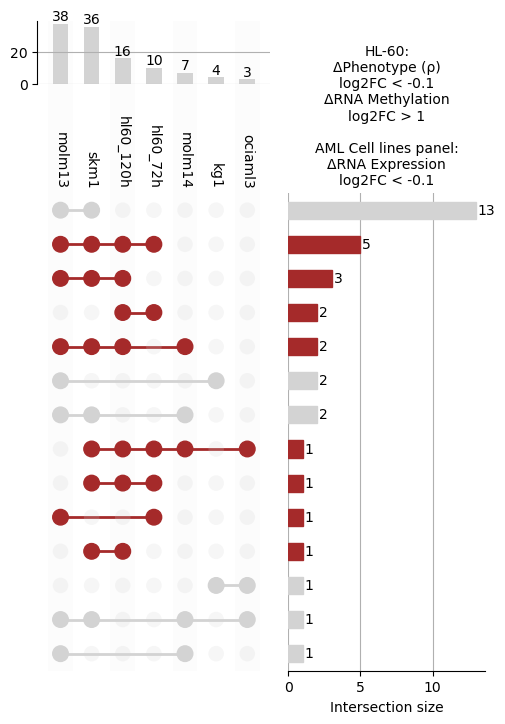

In [18]:
# Expression upset plot
fig1 = plt.figure()
upset1 = us.UpSet(
    us.from_contents(exp_upset_data),
    min_degree=2,
    sort_by='cardinality',
    orientation='vertical',
    show_counts=True,
    # totals_plot_elements=10,
    other_dots_color=0.2,
    facecolor='lightgrey'
)
upset1.style_subsets(
    present=["hl60_72h"], 
    # label="", 
    facecolor='brown'
)
upset1.style_subsets(
    present=["hl60_120h"], 
    facecolor='brown'
)

upset1.plot(fig=fig1)
plt.title(
    "HL-60:\nΔPhenotype (ρ)\nlog2FC < -0.1\nΔRNA Methylation\nlog2FC > 1\n\nAML Cell lines panel:\nΔRNA Expression\nlog2FC < -0.1",
    fontsize=10,#fontweight='bold'
)
plt.savefig('cell-line-consistency/intersection_exp_upset_plot.pdf',dpi=300)
plt.show()

In [19]:
set(upset_to_intersect(exp_upset_data, extract = ['hl60_120h','hl60_72h'])) - \
set(upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','hl60_72h']))

{'MYBBP1A', 'RBM14-RBM4', 'RNF126', 'SLC7A6'}

In [20]:
upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','hl60_72h'])

['INTS5', 'DHODH', 'ZNF777', 'SQLE', 'PMPCA']

In [21]:
upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','molm14'])

['XRCC2', 'SMC4']

In [22]:
set(upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h'])) - \
set(upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','hl60_72h'])) - \
set(upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','molm14']))

{'CCP110', 'RABEP1', 'USP37'}

In [23]:
upset_to_intersect(exp_upset_data, extract = ['hl60_120h','skm1'])

['INTS5',
 'MYBBP1A',
 'RNF126',
 'DHODH',
 'ZNF777',
 'SQLE',
 'PMPCA',
 'CCP110',
 'XRCC2',
 'USP37',
 'RABEP1',
 'FAT1',
 'SMC4']

In [24]:
upset_to_intersect(exp_upset_data, extract = ['hl60_120h','skm1','molm13'])

['INTS5',
 'DHODH',
 'ZNF777',
 'SQLE',
 'PMPCA',
 'CCP110',
 'XRCC2',
 'USP37',
 'RABEP1',
 'SMC4']

In [25]:
upset_to_intersect(exp_upset_data, extract = ['hl60_120h','skm1','ociaml3'])

['MYBBP1A']

In [26]:
set(upset_to_intersect(exp_upset_data, extract = ['hl60_120h','hl60_72h','skm1'])) - \
set(upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','hl60_72h']))

{'MYBBP1A', 'RNF126'}

In [27]:
set(upset_to_intersect(exp_upset_data, extract = ['hl60_72h','molm13'])) - \
set(upset_to_intersect(exp_upset_data, extract = ['molm13','skm1','hl60_120h','hl60_72h']))

{'INO80D'}

In [28]:
set(upset_to_intersect(exp_upset_data, extract = ['molm13','molm14']))

{'BCL2', 'EIF3A', 'HEBP2', 'LIN9', 'SMC4', 'XRCC2'}

In [29]:
set(upset_to_intersect(exp_upset_data, extract = ['ociaml3','kg1']))

{'PRDM15'}

In [30]:
set(upset_to_intersect(exp_upset_data, extract = ['molm13','kg1']))

{'GSK3B', 'PTEN'}

In [31]:
[comp for comp,genes in exp_upset_data.items() if 'PTEN' in genes]

['kg1', 'molm13']

> #### Role and potential for therapeutic targeting of MYB in leukemia
> - https://www.nature.com/articles/leu2012225
> - The NRD is believed to act at least in part by the recruitment of co-repressors, such as TIF1β and __Mybbp1a__, that interfere with target gene activation.

> #### DHODH inhibition synergizes with DNA-demethylating agents in the treatment of myelodysplastic syndromes
> - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7839369/

In [32]:
# ol_genes = list({gene for _, genes in exp_upset_data.items() for gene in genes})
# ol_genes.sort()

In [33]:
# ol_genes

## Stbl

In [34]:
cell_lines = {}

for fc, pval in zip(comps['delta_stbl'].columns[1::2],  comps['delta_stbl'].columns[2::2]):
    
    print (fc.replace('_log2FC',''))
    _,exp_down = find_top(comps['delta_stbl'].dropna(),fc, 0.1, pval, 0.05,silent=True)
    print (20*'_')
    
    cell_lines[fc.replace('_log2FC','')] = list(set(
        exp_down.gene_name.tolist()).intersection(set(
        Ci_down.index.tolist())).intersection(set(
        mtyl_up.gene_name)))
    print(len(cell_lines[fc.replace('_log2FC','')]))

del cell_lines['hl60_6h']

hl60_120h
____________________
6
hl60_72h
____________________
2
hl60_6h
____________________
2
kg1
____________________
2
molm13
____________________
16
molm14
____________________
3
ociaml3
____________________
0
skm1
____________________
14


In [35]:
stbl_upset_data = dict([(c,cell_lines[c]) for c in cell_lines if cell_lines[c]])

In [36]:
stbl_upset_data.keys()

dict_keys(['hl60_120h', 'hl60_72h', 'kg1', 'molm13', 'molm14', 'skm1'])

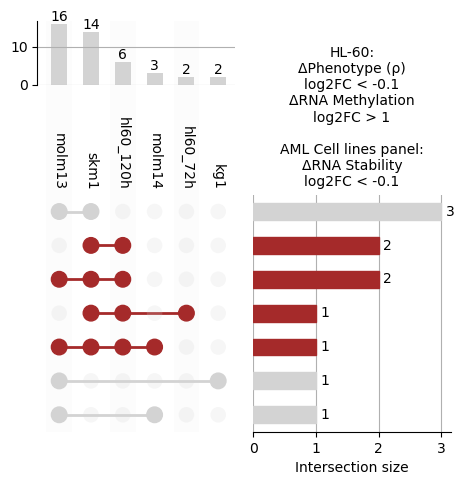

In [37]:
# Stability upset plot
fig1 = plt.figure()
upset1 = us.UpSet(
    us.from_contents(stbl_upset_data),
    min_degree=2,
    sort_by='cardinality',
    orientation='vertical',
    show_counts=True,
    # totals_plot_elements=10,
    other_dots_color=0.2,
    facecolor='lightgrey'
)
upset1.style_subsets(
    present=["hl60_72h"], 
    # label="", 
    facecolor='brown'
)
upset1.style_subsets(
    present=["hl60_120h"], 
    facecolor='brown'
)

upset1.plot(fig1)


plt.title(
    "HL-60:\nΔPhenotype (ρ)\nlog2FC < -0.1\nΔRNA Methylation\nlog2FC > 1\n\nAML Cell lines panel:\nΔRNA Stability\nlog2FC < -0.1",
    fontsize=10,#fontweight='bold'
)
plt.savefig('cell-line-consistency/intersection_stbl_upset_plot.pdf',dpi=300)
plt.show()

In [37]:
upset_to_intersect(stbl_upset_data, extract = ['hl60_120h','skm1'])

['HNRNPUL1', 'TMEM186', 'PMPCA', 'THUMPD2', 'BCL2', 'INTS5']

In [38]:
upset_to_intersect(stbl_upset_data, extract = ['molm13','skm1','hl60_120h'])

['HNRNPUL1', 'TMEM186', 'BCL2']

In [39]:
set(upset_to_intersect(stbl_upset_data, extract = ['molm13','skm1'])) - \
set(upset_to_intersect(stbl_upset_data, extract = ['molm13','skm1','hl60_120h','molm14'])) - \
set(upset_to_intersect(stbl_upset_data, extract = ['molm13','skm1','hl60_120h','molm14']))

{'CREB1', 'HNRNPUL1', 'PPP4R2', 'TMEM186', 'XRCC2'}

In [39]:
upset_to_intersect(stbl_upset_data, extract = ['molm13','skm1','hl60_120h','molm14'])

['BCL2']

In [40]:
upset_to_intersect(stbl_upset_data, extract = ['skm1','hl60_120h','hl60_72h'])

['INTS5']

In [41]:
upset_to_intersect(stbl_upset_data, extract = ['molm14','molm13'])

['BCL2', 'PTTG1IP']

In [42]:
[comp for comp,genes in stbl_upset_data.items() if 'PTEN' in genes]

['molm13']

### heatmap

In [44]:
# df = pd.concat({
#     'Expression':us.from_contents(exp_upset_data).reset_index().set_index('id').astype(int),
#     'Stability':us.from_contents(stbl_upset_data).reset_index().set_index('id').astype(int)
# },axis=1).replace(np.nan,0).astype(int)

# df = df[df.sum(axis=1)>2]

In [45]:
# import PyComplexHeatmap
# from PyComplexHeatmap import *

In [46]:
# df_col = df.columns.to_frame()

In [47]:
# cm = ClusterMapPlotter(data=df,
#                        # col_cluster=True,row_cluster=True,
#                        col_split=df_col[[0]],
#                        col_split_gap=0.5,row_split_gap=0.8,
#                        # label='values',row_dendrogram=True,
#                        show_rownames=True,show_colnames=True,
#                        tree_kws={'row_cmap': 'Set1'},verbose=0,legend_gap=5,
#                        cmap='Greys',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'}
#                       )
# plt.savefig("cell-line-consistency/heatmap.pdf", bbox_inches='tight')
# plt.show()

In [48]:
# df_screens = merge_screen_data(cells=['hl60','molm13','skm1'],exps=['exp1','exp'],scores=['rho'],data=scrns).loc[df.index,:]

In [49]:
# _,dn1 = find_top(df_screens,
#          'hl60_exp1_rho score',0.1, 
#          'hl60_exp1_rho pvalue', 0.05
# )

# _,dn2 = find_top(df_screens,
#          'molm13_exp_rho score',0.1, 
#          'molm13_exp_rho pvalue', 0.05
# )

# _,dn3 = find_top(df_screens,
#          'skm1_exp_rho score',0.1, 
#          'skm1_exp_rho pvalue', 0.05
# )

<!-- No resistance hits! -->

In [50]:
# set(df.index) - set(dn1.index.to_list())

In [51]:
# df_screens.loc['BCL2',:]

In [52]:
# dn2.index.to_list()

In [53]:
# dn3.index.to_list()

In [54]:
# df.style.background_gradient(cmap='Blues')

# 

In [55]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-09-06T01:15:53.316933-07:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
sys       : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
matplotlib: 3.6.2
numpy     : 1.23.5
seaborn   : 0.12.1
upsetplot : 0.8.0
pandas    : 1.5.2

